<a href="https://colab.research.google.com/github/jhelsas/CognitivoAirbnbTest/blob/master/Cognitivo_airbnb_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste tecnico - Airbnb data - Cognitivo.ai

Começamos por carregar as principais bibliotecas básicas para o trabalho em questão: Numpy, Pandas e Scikit-Learn

O projeto escolhdo é para a predição de preços da estadia no Airbnb - Rio de Janeiro

In [0]:
import numpy as np
import pandas as pd
import sklearn as sl

Para baixar os dados eu preferir instalar a wget de python, abaixo

In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=60e5554d1041b55a8122943bdaf1757409644ea63c03647aaebbe91e5a0b2f94
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget 

Baixados os principais csv comprimidos para o trabalho em questão: listings, calendar e reviews. Esses arquivos são baixos e lidos usando pandas read_csv com a opção de descomprimir via gzip, e no caso da listings eu fiz a escolha de ler a coluna 'price' como string para ser processada depois.

In [4]:
wget.download('http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2019-11-22/data/listings.csv.gz','./listings.csv.gz')

'./listings.csv.gz'

In [5]:
wget.download('http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2019-11-22/data/calendar.csv.gz','./calendar.csv.gz')

'./calendar.csv.gz'

In [6]:
wget.download('http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2019-11-22/data/reviews.csv.gz','./reviews.csv.gz')

'./reviews.csv.gz'

In [7]:
listings = pd.read_csv('listings.csv.gz', compression='gzip',error_bad_lines=False,dtype={'price':str})
calendar = pd.read_csv('calendar.csv.gz', compression='gzip',error_bad_lines=False)
reviews  = pd.read_csv('reviews.csv.gz' , compression='gzip',error_bad_lines=False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Visualização Inicial : Exploração dos dados

Para ter-se uma noção inicial do que está se lidando a melhor maneira de começar é dispondo na tela o conteúdo das três tabelas.

In [8]:
display(listings)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20191122092441,2019-11-22,Very Nice 2Br - Copacabana - WiFi,Pls note that special rates apply for Carnival...,- large balcony which looks out on pedestrian ...,Pls note that special rates apply for Carnival...,none,This is the best spot in Rio. Everything happe...,NaN,Excellent location. Close to all major public ...,The entire apartment is yours. It's like your ...,I will be available throughout your stay shoul...,Please leave the apartment in a clean fashion ...,NaN,NaN,https://a0.muscache.com/im/pictures/65320518/3...,NaN,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,$63.00,4,30,4,4,30,30,4.0,30.0,a week ago,t,23,31,35,303,2019-11-22,243,27,2010-07-15,2019-11-11,93.0,9.0,10.0,10.0,10.0,10.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1,0,0,2.13
1,25026,https://www.airbnb.com/rooms/25026,20191122092441,2019-11-22,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,"For any stay superior to 15 days, an additiona...",At night we recommend you to take taxis only. ...,"internet wi-fi, cable tv, air cond, ceiling fa...","Only at check in, we like to leave our guests ...",Smoking outside only. Family building so pleas...,NaN,NaN,https://a0.muscache.com/im/pictures/3003965/68...,NaN,102840,https://www.airbnb.com/users/show/102840,Viviane,2010-04-03,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Hi guys, We're a lovely team of 3 people:\r\n\...",within a day,91%,NaN,f,https://a0.muscache.com/im/pictures/user/9e204...,https://a0.muscache.com/im/pictures/user/9e204...,Copacabana,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Rio de Janeiro, Brazil",Copacabana,Copacabana,...,$45.00,7,60,7,7,60,60,7.0,60.0,5 weeks ago,t,16,22,35,119,2019-11-22,235,17,2010-06-07,2019-10-08,94.0,9.0,10.0,9.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,3,3,0,0,2.04
2,31560,https://www.airbnb.com/rooms/31560,20191122092441,2019-11-22,NICE & COZY 1BDR - IPANEMA BEACH,

In [9]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [10]:
display(reviews)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,17878,64852,2010-07-15,135370,Tia,This apartment is in a perfect location -- two...
1,17878,76744,2010-08-11,10206,Mimi,we had a really great experience staying in Ma...
2,17878,91074,2010-09-06,80253,Jan,Staying in Max appartment is like living in a ...
3,17878,137528,2010-11-12,230449,Orene,In general very good and reasonable price.\r\n...
4,17878,147594,2010-12-01,219338,David,The apt was nice and in a great location only ...
...,...,...,...,...,...,...
316051,40157438,565279567,2019-11-17,310155650,Andrea,The host canceled this reservation 44 days bef...
316052,40237024,567395895,2019-11-22,138627562,Thiago,The host canceled this reservation 36 days bef...
316053,40251786,567015379,2019-11-21,4792833,Padraig,The host canceled this reservation 40 days bef...
316054,40266786,567192792,2019-11-21,232735567,Bárbara,The host canceled this reservation 37 days bef...


In [11]:
display(calendar)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3042602,2019-11-22,t,"$1,679.00","$1,679.00",1.0,1125.0
1,3042602,2019-11-23,t,"$1,679.00","$1,679.00",1.0,1125.0
2,3042602,2019-11-24,t,"$1,679.00","$1,679.00",1.0,1125.0
3,3042602,2019-11-25,t,"$1,679.00","$1,679.00",1.0,1125.0
4,3042602,2019-11-26,t,"$1,679.00","$1,679.00",1.0,1125.0
...,...,...,...,...,...,...,...
12305875,40160845,2020-11-16,f,$190.00,$190.00,1.0,1125.0
12305876,40160845,2020-11-17,f,$190.00,$190.00,1.0,1125.0
12305877,40160845,2020-11-18,f,$190.00,$190.00,1.0,1125.0
12305878,40160845,2020-11-19,f,$190.00,$190.00,1.0,1125.0


Uma das features mais importantes para predizer o preço provavelmente é o tipo de quarto. Não faria sentido algum um quarto compartilhado ser ofertado igual a um apartamento inteiro dado todas as outras variáveis iguais. Portanto é útil saber quais opções de tipos de quarto existem.

In [12]:
print(listings['room_type'].unique())

['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


A coluna de preços está em forma de texto. Para ser mais fácil de ser usada como alvo para o processo de aprendizado supervisionado é importante converter os valores de texto em moeda para um valor em float. Isto será feito mapeando uma conversão via locale.atof na coluna, removendo-se antes o caracter '$'

In [13]:
calendar['price']

0           $1,679.00
1           $1,679.00
2           $1,679.00
3           $1,679.00
4           $1,679.00
              ...    
12305875      $190.00
12305876      $190.00
12305877      $190.00
12305878      $190.00
12305879      $190.00
Name: price, Length: 12305880, dtype: object

In [14]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

'en_US.UTF8'

In [0]:
calendar['price']=calendar.price.astype(str).map(lambda x: locale.atof(x.strip('$')))

In [0]:
calendar['adjusted_price']=calendar.adjusted_price.astype(str).map(lambda x: locale.atof(x.strip('$')))

Agora com os dados de preço em um formato manejável, é útil se ter uma noção da distribuição de valores da própria variável preço, sem levar em consideração ainda as outras variáveis que podem ser usadas para determina-la. Para isso se uilizará pyplot.hist para se produzir a pdf e a cdf dos valores de preço.

In [0]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


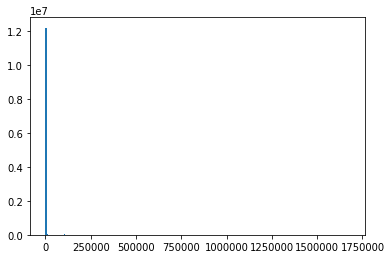

In [18]:
plt.hist(calendar['price'],bins=200)
plt.show()

Como podemos ver, a distribuição possui uma cauda extremamente longa, o que é condizente com a disparidade de valores entre diferentes imóveis no Rio de Janeiro. Um apartamento no Leblon possui um preço de aluguel radicalmente diferente de um quarto compartilhado na Tijuca. Para podermos ter uma noção melhor de como de fato os dados se comportam é mais útil plotar em escala log, o que fazemos abaixo. 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.471430e+05, 7.900890e+05, 2.144223e+06, 2.538391e+06,
        2.410049e+06, 1.615253e+06, 1.383341e+06, 6.584800e+05,
        2.730010e+05, 1.199080e+05, 4.842600e+04, 2.517500e+04,
        9.147000e+03, 5.677000e+03, 3.691000e+04, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.050000e+02]),
 array([1.47712125, 1.71452957, 1.95193789, 2.1893462 , 2.42675452,
        2.66416283, 2.90157115, 3.13897946, 3.37638778, 3.6137961 ,
        3.85120441, 4.08861273, 4.32602104, 4.56342936, 4.80083767,
        5.03824599, 5.2756543 , 5.51306262, 5.75047094, 5.98787925,
        6.22528757]),
 <a list of 20 Patch objects>)

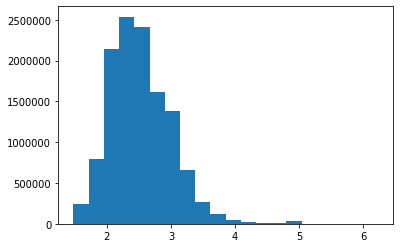

In [19]:
plt.hist(np.log(calendar['price'])/np.log(10),bins=20)

Como vemos aqui, a cauda ainda existe mas a estrutura principal da distribuição é mais visível no plot log, com um pico em volta de $10^{2.5} \approx 320$ reais. No entanto existem listagens que chegam a R$ 10.000 a 100.000 . Para um projeto de regressão, valores tão elevados tem a chance de distorcer os resultados, portanto, num trabalho preliminar como o feito aqui, eles serão removidos. Para tratar esses valores corretamente pode ser necessário fazer uma análise de outliers.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.477170e+05, 7.934100e+05, 2.143049e+06, 2.538246e+06,
        2.409119e+06, 1.614927e+06, 1.382107e+06, 6.585330e+05,
        2.733680e+05, 1.196260e+05, 4.821200e+04, 2.516700e+04,
        9.331000e+03, 5.491000e+03, 3.691000e+04, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.050000e+02]),
 array([1.47712125, 1.71452957, 1.95193789, 2.1893462 , 2.42675452,
        2.66416283, 2.90157115, 3.13897946, 3.37638778, 3.6137961 ,
        3.85120441, 4.08861273, 4.32602104, 4.56342936, 4.80083767,
        5.03824599, 5.2756543 , 5.51306262, 5.75047094, 5.98787925,
        6.22528757]),
 <a list of 20 Patch objects>)

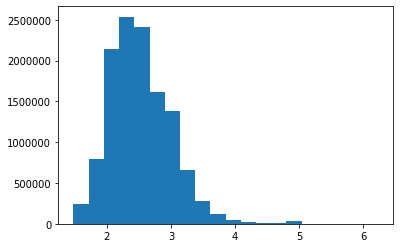

In [20]:
plt.hist(np.log(calendar['adjusted_price'])/np.log(10),bins=20)

Como vemos, a feature 'adjusted_price' não adiciona nenhuma informação adicional, portanto será ignorada.

Para se escolher como se livrar dos outliers, procuraremos o 99 percentil da distribuição acumulada. O valor da abscissa onde a reta $y=0.99$ intersecta a cdf nos proverá o cutoff. 

Plotando apenas a reta horizontal obtemos o gráfico seguinte:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


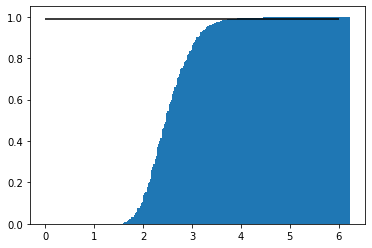

In [21]:
plt.hist(np.log(calendar['price'])/np.log(10),bins=200,cumulative=True,normed=True,histtype ='bar')
plt.hlines(0.99,0,6)

O valor do corte é na região pouco antes de $\log (price) = 4.0$, plotando agora a cdf usando uma curva vazia e com o a reta vertical identificamos o cutoff em $\log (price) = 3.85$, como vejos no gráfico abaixo.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.9, 1.0)

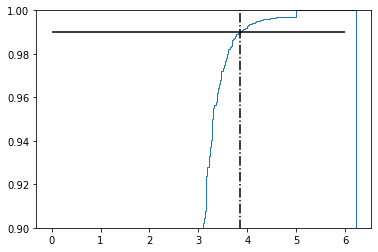

In [22]:
plt.hist(np.log(calendar['price'])/np.log(10),bins=200,cumulative=True,normed=True,histtype ='step')
plt.hlines(0.99,0,6)
plt.vlines(3.85,0,1,ls='-.')
plt.ylim((0.9,1.0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.9, 1.0)

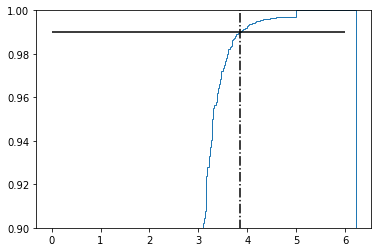

In [23]:
plt.hist(np.log(calendar['adjusted_price'])/np.log(10),bins=200,cumulative=True,normed=True,histtype ='step')
plt.hlines(0.99,0,6)
plt.vlines(3.85,0,1,ls='-.')
plt.ylim((0.9,1.0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.9, 1.0)

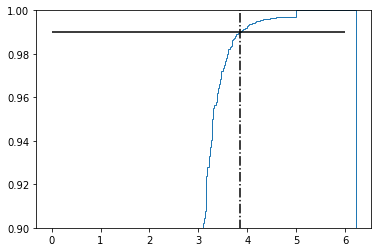

In [24]:
plt.hist(np.log(calendar['adjusted_price'])/np.log(10),bins=200,cumulative=True,normed=True,histtype ='step')
plt.hlines(0.99,0,6)
plt.vlines(3.85,0,1,ls='-.')
plt.ylim((0.9,1.0))

O valor de preço fica portanto em $10^{3.85} = 7079.45$, assim sendo adotaremos um valor de cutoff em 7080. Essa escolha é arbitrária mas feita com base no raciocínio discutido anteriormente.

In [25]:
10**(3.85)

7079.457843841381

In [0]:
cutoff = 7080

Plotando agora a pdf dos dados em que foram removidos os outliers, vemos que o pior da cauda longa foi removida, facilitando assim a modelagem. Ainda assim, vemos que precisamos nos manter no log do preço para nos obtermos um intervalo razoavel para os dados, e é o que usaremos como alvo para o processo de regressão. 

Note, no entanto, que esta escolha é menos artificial do que aparenta num primeiro momento. Os erros, na maior parte dos modelos simples, são calculados como valores fixos, e não como percentual do valor predito. No caso de preço, um erro global no modelo de valor R$ 300 seria perfeitamente aceitável se o valor predito fosse na faixa de BRL 2500-3500, mas claramente inaceitável se o imóvel em questão fosse listado por BRL 80-200. 

Assim sendo, faria mais sentido procurar predições que nos retornassem erros percentuais. 30 porcento de erro em BRL 80 e em BRL 2500 podem ser ambos aceitáveis dependendo do caso. Para se obter modelos que retornem errors e/ou incertezas percentuais a maneira mais simples é fazer uma regressão no logaritmo dos valores. 

In [0]:
clean_calendar = calendar[calendar['price']<cutoff]

(array([  15599.,  231544.,  249481.,  540608.,  860375., 1283848.,
        1396882., 1139552., 1377725., 1024485., 1053606.,  569202.,
         889459.,  495634.,  401010.,  257582.,  173474.,   99403.,
          82984.,   37410.]),
 array([1.47712125, 1.59568389, 1.71424652, 1.83280915, 1.95137178,
        2.06993441, 2.18849704, 2.30705967, 2.42562231, 2.54418494,
        2.66274757, 2.7813102 , 2.89987283, 3.01843546, 3.1369981 ,
        3.25556073, 3.37412336, 3.49268599, 3.61124862, 3.72981125,
        3.84837388]),
 <a list of 20 Patch objects>)

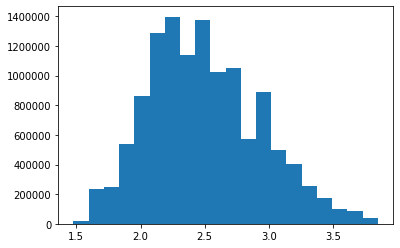

In [28]:
plt.hist(np.log(clean_calendar['price'])/np.log(10),bins=20)

Fazendo uma análise visual foram escolhidas as features 'date', 'neighbourhood', 'property_type' e 'bed_type'. Como haviamos discutido anteriormente, localização e tipo de imóvel certamente influenciam no preço. A confirmação desta hipótese deve ser feita fazendo-se uma análise de correlação para a qual eu não possuo tempo. Similarmente tipo de cama influencia. 

Data faz sentido influenciar já que o Rio de Janeiro enxe no carnaval e no ano novo, mas em agosto não possue nem perto do mesmo volume de turista. No entanto, na nossa análise, não faremos uma análise complexa usando a feature 'Date'. No lugar usaremos como alvo da regressão a média no tempo do preço dos diferentes imóveis. 

Uma análise mais sofisticada poderia quebrar as datas em meses e usar o mês como feature de predição. Novamente, não tenho tempo para esta análise no momento. 

Para alimentarmos o modelo de aprendizado, unificamos os dados das das tabelas listings e calendar via um left_join a partir do calendar.

In [0]:
#merged = pd.merge(clean_calendar,listings,how='left',left_on='listing_id',right_on='id')
merged = pd.merge(clean_calendar[['listing_id','date','price']],listings[['id','neighbourhood','zipcode','property_type','bed_type']],how='left',left_on='listing_id',right_on='id')

In [0]:
merged = merged.drop('id',axis=1)

In [0]:
del(listings); del(calendar); del(reviews); del(clean_calendar)

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [92]:
display(merged.head(5))

,listing_id,date,price,neighbourhood,zipcode,property_type,bed_type
0,3042602,2019-11-22,1679.0,Centro,20230080\n202300,Apartment,Real Bed
1,3042602,2019-11-23,1679.0,Centro,20230080\n202300,Apartment,Real Bed
2,3042602,2019-11-24,1679.0,Centro,20230080\n202300,Apartment,Real Bed
3,3042602,2019-11-25,1679.0,Centro,20230080\n202300,Apartment,Real Bed
4,3042602,2019-11-26,1679.0,Centro,20230080\n202300,Apartment,Real Bed


Analizando visualmente os valores presentes em cada uma das features obtemos as listas seguintes. Isso será necessário porque essas features terão que ser one-hot encoding antes de ser alimentado no modelo de regressão. 

Esta exploração também foi feita para outras features que não estão mostradas aqui.

neighbourhood, zipcode, property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,weekly_price,monthly_price, availability_365,review_scores_cleanliness, license,

In [93]:
print(merged['property_type'].unique())

['Apartment' 'Condominium' 'Loft' 'House' 'Guesthouse' 'Villa'
 'Serviced apartment' 'Bed and breakfast' 'Cottage' 'Guest suite' 'Hotel'
 'Hostel' 'Chalet' 'Bungalow' 'Boutique hotel' 'Aparthotel' 'Other'
 'Earth house' 'Townhouse' 'Boat' 'Treehouse' 'Nature lodge' 'Tiny house'
 'Cabin' 'Castle' 'Island' 'Hut' 'Campsite' 'Casa particular (Cuba)'
 'Camper/RV' 'Igloo']


In [94]:
print(merged['bed_type'].unique())

['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']


In [95]:
print(merged['neighbourhood'].unique())

['Centro' 'Pilares' 'Ipanema' 'Tijuca' 'Leblon' 'Glória' 'Lapa' 'Joá'
 'Leme' 'Lagoa' 'Grajaú' 'Catete' 'Urca' 'Jacaré' 'Rocha' 'Maracanã'
 'Gávea' 'Barra da Tijuca' 'Vidigal' 'Copacabana' 'Botafogo'
 'Santa Teresa' 'Humaitá' 'Flamengo' 'Recreio dos Bandeirantes'
 'São Conrado' 'Laranjeiras' 'Marechal Hermes' 'Jardim Botânico'
 'Santo Cristo' 'Vila da Penha' 'São Cristóvão' 'Cosme Velho' 'Estacio'
 'Vila Isabel' 'Penha Circular' 'Irajá' 'Rio Comprido' 'Praça da Bandeira'
 'Encantado' 'Lins de Vasconcelos' 'Bonsucesso' 'Gamboa' 'Piedade'
 'Olaria' 'Bento Ribeiro' 'Riachuelo' 'Barra de Guaratiba' 'Andaraí'
 'Cidade Nova' 'Del Castilho' 'Rocinha' 'Engenho de Dentro' 'Engenho Novo'
 'Benfica' 'Maria da Graça' 'Cachambi' 'Cavalcante' 'Higienópolis'
 'Cascadura' 'Méier' 'Todos os Santos' 'Engenho da Rainha' 'Rocha Miranda'
 'Vaz Lobo' 'Cordovil' 'Guadalupe' 'Madureira' 'Oswaldo Cruz'
 'Vincente de Carvalho' 'Penha' 'Saúde' 'Sampaio' 'Parada de Lucas'
 'Quintino Bocaiúva' 'Brás de Pina' 'Pavu

Observamo que existe o valor 'nan' na lista de possíveis valores da feature 'neighbourhood'. Isto pode ser prejudicial para o modelo de regressão, portanto removeremos todas as linhas que possuam valor nan. Isso poderia ser contornado talvez usando o valor do zipcode, mas não fizemos isto aqui.

Para retirar os valores nan, utilizamos o método isnull da série. E utilizamos isso para selecionar os valores que não são null. 

In [96]:
np.logical_not(merged['neighbourhood'].isnull())

0           True
1           True
2           True
3           True
4           True
            ... 
12179493    True
12179494    True
12179495    True
12179496    True
12179497    True
Name: neighbourhood, Length: 11472791, dtype: bool

In [0]:
merged = merged[np.logical_not(merged['neighbourhood'].isnull())]

In [98]:
print(merged['listing_id'].unique())

[ 3042602  3042549  3042557 ... 40157671 40159017 40159281]


Vemos agora que os valores nan foram reirados.

In [99]:
print(merged['neighbourhood'].unique())

['Centro' 'Pilares' 'Ipanema' 'Tijuca' 'Leblon' 'Glória' 'Lapa' 'Joá'
 'Leme' 'Lagoa' 'Grajaú' 'Catete' 'Urca' 'Jacaré' 'Rocha' 'Maracanã'
 'Gávea' 'Barra da Tijuca' 'Vidigal' 'Copacabana' 'Botafogo'
 'Santa Teresa' 'Humaitá' 'Flamengo' 'Recreio dos Bandeirantes'
 'São Conrado' 'Laranjeiras' 'Marechal Hermes' 'Jardim Botânico'
 'Santo Cristo' 'Vila da Penha' 'São Cristóvão' 'Cosme Velho' 'Estacio'
 'Vila Isabel' 'Penha Circular' 'Irajá' 'Rio Comprido' 'Praça da Bandeira'
 'Encantado' 'Lins de Vasconcelos' 'Bonsucesso' 'Gamboa' 'Piedade'
 'Olaria' 'Bento Ribeiro' 'Riachuelo' 'Barra de Guaratiba' 'Andaraí'
 'Cidade Nova' 'Del Castilho' 'Rocinha' 'Engenho de Dentro' 'Engenho Novo'
 'Benfica' 'Maria da Graça' 'Cachambi' 'Cavalcante' 'Higienópolis'
 'Cascadura' 'Méier' 'Todos os Santos' 'Engenho da Rainha' 'Rocha Miranda'
 'Vaz Lobo' 'Cordovil' 'Guadalupe' 'Madureira' 'Oswaldo Cruz'
 'Vincente de Carvalho' 'Penha' 'Saúde' 'Sampaio' 'Parada de Lucas'
 'Quintino Bocaiúva' 'Brás de Pina' 'Pavu

Chegamos agora a uma tabela limpa que é funcionalmente util para ser alimentada no modelo de regressão. 

In [100]:
display(merged.sample(10))

,listing_id,date,price,neighbourhood,zipcode,property_type,bed_type
7978568,22366388,2020-01-10,177.0,Santa Teresa,20241-040,Other,Real Bed
5640370,13996832,2020-08-13,500.0,Barra da Tijuca,NaN,Apartment,Real Bed
8373180,23397227,2020-05-30,392.0,Ipanema,22420-040,Apartment,Real Bed
3773997,11755099,2020-06-11,251.0,Barra da Tijuca,22620-311,Apartment,Real Bed
3094719,10402311,2020-11-02,800.0,Flamengo,22230,Apartment,Real Bed
10535546,34531621,2020-09-27,200.0,Barra da Tijuca,22621-160,Apartment,Real Bed
7668050,21446053,2020-10-11,250.0,Copacabana,22011-010,Apartment,Real Bed
7263162,19539394,2020-03-27,2000.0,Ipanema,22420-042,Apartment,Real Bed
8914545,28535495,2020-03-21,300.0,Copacabana,22071-100,Apartment,Real Bed
2729806,9350695,2020-06-16,230.0,Centro,20230-014,Apartment,Real Bed


(array([  12684.,  204199.,  224631.,  494090.,  794837., 1204583.,
        1324670., 1086812., 1313220.,  974673., 1003783.,  531853.,
         842371.,  464774.,  382782.,  242534.,  163343.,   92523.,
          77754.,   36675.]),
 array([1.47712125, 1.59568389, 1.71424652, 1.83280915, 1.95137178,
        2.06993441, 2.18849704, 2.30705967, 2.42562231, 2.54418494,
        2.66274757, 2.7813102 , 2.89987283, 3.01843546, 3.1369981 ,
        3.25556073, 3.37412336, 3.49268599, 3.61124862, 3.72981125,
        3.84837388]),
 <a list of 20 Patch objects>)

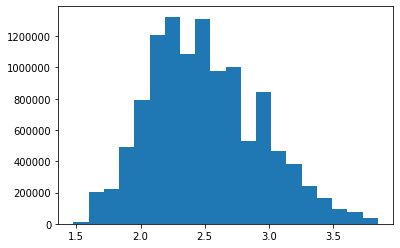

In [101]:
plt.hist(np.log(merged['price'])/np.log(10),bins=20)

Reindexamos a tabela para podermos fazer a média nas datas antes de rodar o algoritmo de regressão. Isso é feito rodando o método mean nos níveis correspondentes aos indices anteriores. 

In [0]:
table = merged.set_index(['listing_id','neighbourhood','zipcode','property_type','bed_type','date'])

(array([  12684.,  204199.,  224631.,  494090.,  794837., 1204583.,
        1324670., 1086812., 1313220.,  974673., 1003783.,  531853.,
         842371.,  464774.,  382782.,  242534.,  163343.,   92523.,
          77754.,   36675.]),
 array([1.47712125, 1.59568389, 1.71424652, 1.83280915, 1.95137178,
        2.06993441, 2.18849704, 2.30705967, 2.42562231, 2.54418494,
        2.66274757, 2.7813102 , 2.89987283, 3.01843546, 3.1369981 ,
        3.25556073, 3.37412336, 3.49268599, 3.61124862, 3.72981125,
        3.84837388]),
 <a list of 20 Patch objects>)

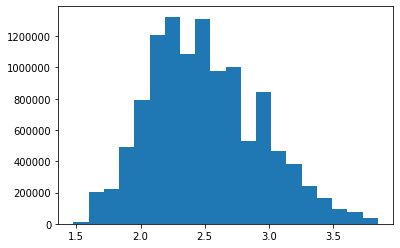

In [103]:
plt.hist(np.log(table['price'])/np.log(10),bins=20)

In [104]:
display(table)

price
listing_id neighbourhood zipcode          property_type bed_type date              
3042602    Centro        20230080\n202300 Apartment     Real Bed 2019-11-22  1679.0
                                                                 2019-11-23  1679.0
                                                                 2019-11-24  1679.0
                                                                 2019-11-25  1679.0
                                                                 2019-11-26  1679.0
...                                                                             ...
40159281   Piedade       20751-380        Tiny house    Real Bed 2020-11-16   120.0
                                                                 2020-11-17   120.0
                                                                 2020-11-18   120.0
                                                                 2020-11-19   120.0
                                                                 2020-11-20   120.0

[11472791 rows x 1 columns]

In [105]:
table.loc[3042602,:]

price
neighbourhood zipcode          property_type bed_type date              
Centro        20230080\n202300 Apartment     Real Bed 2019-11-22  1679.0
                                                      2019-11-23  1679.0
                                                      2019-11-24  1679.0
                                                      2019-11-25  1679.0
                                                      2019-11-26  1679.0
                                                      2019-11-27  1679.0
                                                      2019-11-28  1679.0
                                                      2019-11-29  1679.0
                                                      2019-11-30  1679.0
                                                      2019-12-01  1679.0
                                                      2019-12-02  1679.0
                                                      2019-12-03  1679.0
                                                      2019-12-04  1679.0
                                                      2019-12-05  1679.0
                                                      2019-12-06  1679.0
                                                      2019-12-07  1679.0
                                                      2019-12-08  1679.0
                                                      2019-12-09  1679.0
                                                      2019-12-10  1679.0
                                                      2019-12-11  1679.0
                                                      2019-12-12  1679.0
                                                      2019-12-13  1679.0
                                                      2019-12-14  1679.0
                                                      2019-12-15  1679.0
                                                      2019-12-16  1679.0
                                                      2019-12-17  1679.0
                                                      2019-12-18  1679.0
                                                      2019-12-19  1679.0
                                                      2019-12-20  1679.0
                                                      2019-12-21  1679.0
                                                      2019-12-22  1679.0
                                                      2019-12-23  1679.0
                                                      2019-12-24  1679.0
                                                      2019-12-25  1679.0
                                                      2019-12-26  1679.0
                                                      2019-12-27  1679.0
                                                      2019-12-28  1679.0
                                                      2019-12-29  1679.0
                                                      2019-12-30  1679.0
                                                      2019-12-31  1679.0
                                                      2020-01-01  1679.0
                                                      2020-01-02  1679.0
                                                      2020-01-03  1679.0
                                                      2020-01-04  1679.0
                                                      2020-01-05  1679.0
                                                      2020-01-06  1679.0
                                                      2020-01-07  1679.0
                                                      2020-01-08  1679.0
                                                      2020-01-09  1679.0
                                                      2020-01-10  1679.0
                                                      2020-01-11  1679.0
                                                      2020-01-12  1679.0
                                                      2020-01-13  1679.0
                                                    

In [106]:
table.loc[40159281,:]

price
neighbourhood zipcode   property_type bed_type date             
Piedade       20751-380 Tiny house    Real Bed 2019-11-22   70.0
                                               2019-11-23   70.0
                                               2019-11-24   70.0
                                               2019-11-25   70.0
                                               2019-11-26   70.0
                                               2019-11-27   70.0
                                               2019-11-28   70.0
                                               2019-11-29   70.0
                                               2019-11-30   70.0
                                               2019-12-01   70.0
                                               2019-12-02   70.0
                                               2019-12-03   70.0
                                               2019-12-04   70.0
                                               2019-12-05   70.0
                                               2019-12-06   70.0
                                               2019-12-07   70.0
                                               2019-12-08   70.0
                                               2019-12-09   70.0
                                               2019-12-10   70.0
                                               2019-12-11   70.0
                                               2019-12-12   70.0
                                               2019-12-13   70.0
                                               2019-12-14   70.0
                                               2019-12-15   70.0
                                               2019-12-16   70.0
                                               2019-12-17   70.0
                                               2019-12-18   70.0
                                               2019-12-19   70.0
                                               2019-12-20   70.0
                                               2019-12-21   70.0
                                               2019-12-22   80.0
                                               2019-12-23   80.0
                                               2019-12-24   80.0
                                               2019-12-25   80.0
                                               2019-12-26   80.0
                                               2019-12-27   80.0
                                               2019-12-28   80.0
                                               2019-12-29   80.0
                                               2019-12-30   80.0
                                               2019-12-31   80.0
                                               2020-01-01   80.0
                                               2020-01-02   80.0
                                               2020-01-03   80.0
                                               2020-01-04   80.0
                                               2020-01-05   80.0
                                               2020-01-06   80.0
                                               2020-01-07   80.0
                                               2020-01-08   80.0
                                               2020-01-09   80.0
                                               2020-01-10   80.0
                                               2020-01-11   80.0
                                               2020-01-12   80.0
                                               2020-01-13   80.0
                                               2020-01-14   80.0
                                               2020-01-15   80.0
                                               2020-01-16   80.0
                                               2020-01-17   80.0
                                               2020-01-18   80.0
                                               2020-01-19   80.0
                                               2020-01-20   80.0
                             

In [107]:
table.loc[3042557,:] 

price
neighbourhood zipcode   property_type bed_type date             
Ipanema       22411-030 Apartment     Real Bed 2019-11-22  798.0
                                               2019-11-23  798.0
                                               2019-11-24  798.0
                                               2019-11-25  798.0
                                               2019-11-26  798.0
                                               2019-11-27  798.0
                                               2019-11-28  798.0
                                               2019-11-29  798.0
                                               2019-11-30  798.0
                                               2019-12-01  798.0
                                               2019-12-02  798.0
                                               2019-12-03  798.0
                                               2019-12-04  798.0
                                               2019-12-05  798.0
                                               2019-12-06  798.0
                                               2019-12-07  798.0
                                               2019-12-08  798.0
                                               2019-12-09  798.0
                                               2019-12-10  798.0
                                               2019-12-11  798.0
                                               2019-12-12  798.0
                                               2019-12-13  798.0
                                               2019-12-14  798.0
                                               2019-12-15  798.0
                                               2019-12-16  798.0
                                               2019-12-17  798.0
                                               2019-12-18  798.0
                                               2019-12-19  798.0
                                               2019-12-20  798.0
                                               2019-12-21  798.0
                                               2019-12-22  798.0
                                               2019-12-23  798.0
                                               2019-12-24  798.0
                                               2019-12-25  798.0
                                               2019-12-26  798.0
                                               2019-12-27  798.0
                                               2019-12-28  798.0
                                               2019-12-29  798.0
                                               2019-12-30  798.0
                                               2019-12-31  798.0
                                               2020-01-01  798.0
                                               2020-01-02  798.0
                                               2020-01-03  798.0
                                               2020-01-04  798.0
                                               2020-01-05  798.0
                                               2020-01-06  798.0
                                               2020-01-07  798.0
                                               2020-01-08  798.0
                                               2020-01-09  798.0
                                               2020-01-10  798.0
                                               2020-01-11  798.0
                                               2020-01-12  798.0
                                               2020-01-13  798.0
                                               2020-01-14  798.0
                                               2020-01-15  798.0
                                               2020-01-16  798.0
                                               2020-01-17  798.0
                                               2020-01-18  798.0
                                               2020-01-19  798.0
                                               2020-01-20  798.0
                             

In [108]:
mean_price = table.mean(level=['listing_id','neighbourhood','zipcode','property_type','bed_type'])

display(mean_price)

,,,,,price
listing_id,neighbourhood,zipcode,property_type,bed_type,
3042602,Centro,20230080\n202300,Apartment,Real Bed,1679.000000
3042549,Pilares,20760-150,Condominium,Real Bed,53.369863
3042557,Ipanema,22411-030,Apartment,Real Bed,798.000000
3165978,Tijuca,20511-390,Apartment,Real Bed,697.000000
3136639,Leblon,22450190,Apartment,Real Bed,2000.000000
...,...,...,...,...,...
40156694,Copacabana,22070-002,Apartment,Real Bed,904.380822
40157438,Barra da Tijuca,22611-201,Loft,Real Bed,476.575342
40157671,Ipanema,22411-030,Apartment,Real Bed,100.000000


(array([  17.,  417.,  599., 1222., 1861., 2762., 3344., 3330., 3161.,
        3171., 2606., 1602., 2107., 1247.,  899.,  692.,  410.,  241.,
         189.,   95.]),
 array([1.47712125, 1.59552009, 1.71391893, 1.83231777, 1.95071661,
        2.06911545, 2.18751429, 2.30591313, 2.42431197, 2.54271081,
        2.66110965, 2.77950849, 2.89790733, 3.01630617, 3.134705  ,
        3.25310384, 3.37150268, 3.48990152, 3.60830036, 3.7266992 ,
        3.84509804]),
 <a list of 20 Patch objects>)

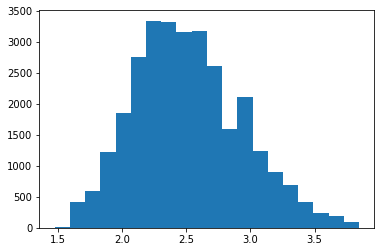

In [109]:
plt.hist(np.log(mean_price['price'])/np.log(10),bins=20)

Rodando reset_index e melt retornamos a uma tabela que possu as features 

In [0]:
molten_price = mean_price.reset_index().melt(['listing_id','neighbourhood','zipcode', 'property_type','bed_type'],value_vars=None,value_name='price')
molten_price = molten_price[['listing_id','neighbourhood','zipcode', 'property_type','bed_type','price']]

In [111]:
display(molten_price)

,listing_id,neighbourhood,zipcode,property_type,bed_type,price
0,3042602,Centro,20230080\n202300,Apartment,Real Bed,1679.000000
1,3042549,Pilares,20760-150,Condominium,Real Bed,53.369863
2,3042557,Ipanema,22411-030,Apartment,Real Bed,798.000000
3,3165978,Tijuca,20511-390,Apartment,Real Bed,697.000000
4,3136639,Leblon,22450190,Apartment,Real Bed,2000.000000
...,...,...,...,...,...,...
29967,40156694,Copacabana,22070-002,Apartment,Real Bed,904.380822
29968,40157438,Barra da Tijuca,22611-201,Loft,Real Bed,476.575342
29969,40157671,Ipanema,22411-030,Apartment,Real Bed,100.000000
29970,40159017,Botafogo,22290-240,Apartment,Real Bed,279.654795


(array([  17.,  417.,  599., 1222., 1861., 2762., 3344., 3330., 3161.,
        3171., 2606., 1602., 2107., 1247.,  899.,  692.,  410.,  241.,
         189.,   95.]),
 array([1.47712125, 1.59552009, 1.71391893, 1.83231777, 1.95071661,
        2.06911545, 2.18751429, 2.30591313, 2.42431197, 2.54271081,
        2.66110965, 2.77950849, 2.89790733, 3.01630617, 3.134705  ,
        3.25310384, 3.37150268, 3.48990152, 3.60830036, 3.7266992 ,
        3.84509804]),
 <a list of 20 Patch objects>)

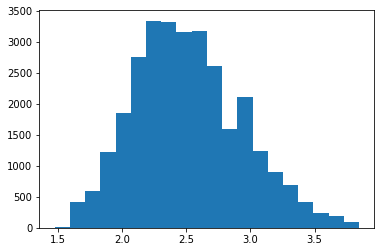

In [112]:
plt.hist(np.log(molten_price['price'])/np.log(10),bins=20)

Como exemplo, vemos exemplos de listagens na tijuca. Observamos que mesmo com mesmo bairro e tipo de cama e apartamento, ainda existe uma variação grande nos preços. Por causa disso tentei incluir o CEP como variável informativa para tentar discernir estes preços. Provavelmente para uma predição mais acurada as datas também seriam importantes.

In [113]:
display(molten_price[molten_price['neighbourhood']=='Tijuca'])

,listing_id,neighbourhood,zipcode,property_type,bed_type,price
3,3165978,Tijuca,20511-390,Apartment,Real Bed,697.000000
19,7887059,Tijuca,20520050,Apartment,Real Bed,200.000000
42,13261860,Tijuca,20511-330,Apartment,Real Bed,1259.000000
45,14084374,Tijuca,20270-231,Apartment,Real Bed,967.000000
70,23106503,Tijuca,20530-001,Apartment,Real Bed,109.890411
...,...,...,...,...,...,...
29202,39577995,Tijuca,20261-105,Apartment,Real Bed,93.065753
29256,39653473,Tijuca,20550-012,Apartment,Real Bed,73.753425
29326,39696368,Tijuca,20530-440,Apartment,Real Bed,250.000000
29368,39712553,Tijuca,20521-160,Apartment,Real Bed,350.000000


Pondo um valor numérico a impressão expressa na inspeção anterior.

In [114]:
chIndx = np.logical_and(np.logical_and( molten_price['neighbourhood']=='Tijuca',molten_price['property_type']=='Apartment' ), molten_price['zipcode']=='20550-012' )

print(molten_price[chIndx]['price'].mean(),molten_price[chIndx]['price'].std())

348.35068493150686 304.927273783219


In [115]:
molten_price

,listing_id,neighbourhood,zipcode,property_type,bed_type,price
0,3042602,Centro,20230080\n202300,Apartment,Real Bed,1679.000000
1,3042549,Pilares,20760-150,Condominium,Real Bed,53.369863
2,3042557,Ipanema,22411-030,Apartment,Real Bed,798.000000
3,3165978,Tijuca,20511-390,Apartment,Real Bed,697.000000
4,3136639,Leblon,22450190,Apartment,Real Bed,2000.000000
...,...,...,...,...,...,...
29967,40156694,Copacabana,22070-002,Apartment,Real Bed,904.380822
29968,40157438,Barra da Tijuca,22611-201,Loft,Real Bed,476.575342
29969,40157671,Ipanema,22411-030,Apartment,Real Bed,100.000000
29970,40159017,Botafogo,22290-240,Apartment,Real Bed,279.654795


# Preparing the Learning model

## One-Hot encoding the data

O primeiro passo para podermos usar o modelo de aprendizado em variáveis categóricas em um problema de regressão é converter as variáveis categóricas para um formato que seja bem adaptado aos cálculos dos modelos. A escolha de codificação que eu fiz foi utilizar one-hot encoding para o trabalho.

No caso da biblioteca pandas, a função que faz isso é a get_dummies. Primeiro inspecionamos o efeito de usar one-hot encoding em cada feature separadamente, principalmente para efeito visual, e depois aplicamos aos dados como um todo. 

In [116]:
pd.get_dummies(molten_price['property_type'])

,Aparthotel,Apartment,Bed and breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Campsite,Casa particular (Cuba),Castle,Chalet,Condominium,Cottage,Earth house,Guest suite,Guesthouse,Hostel,Hotel,House,Hut,Igloo,Island,Loft,Nature lodge,Other,Serviced apartment,Tiny house,Townhouse,Treehouse,Villa
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29967,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29970,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
molten_with_dummies = pd.get_dummies(molten_price, ['neighbourhood','zipcode','property_type','bed_type'])

In [118]:
display(molten_with_dummies)

,listing_id,price,neighbourhood_Abolição,neighbourhood_Anchieta,neighbourhood_Andaraí,neighbourhood_Barra da Tijuca,neighbourhood_Barra de Guaratiba,neighbourhood_Barros Filho,neighbourhood_Benfica,neighbourhood_Bento Ribeiro,neighbourhood_Bonsucesso,neighbourhood_Botafogo,neighbourhood_Brás de Pina,neighbourhood_Cachambi,neighbourhood_Caju,neighbourhood_Cascadura,neighbourhood_Catete,neighbourhood_Catumbi,neighbourhood_Cavalcante,neighbourhood_Centro,neighbourhood_Cidade Nova,neighbourhood_Coelho Neto,neighbourhood_Colégio,neighbourhood_Complexo de Alemão,neighbourhood_Copacabana,neighbourhood_Cordovil,neighbourhood_Cosme Velho,neighbourhood_Del Castilho,neighbourhood_Deodoro,neighbourhood_Encantado,neighbourhood_Engenheiro Leal,neighbourhood_Engenho Novo,neighbourhood_Engenho da Rainha,neighbourhood_Engenho de Dentro,neighbourhood_Estacio,neighbourhood_Flamengo,neighbourhood_Gamboa,neighbourhood_Glória,neighbourhood_Grajaú,neighbourhood_Grumari,neighbourhood_Guadalupe,neighbourhood_Gávea,neighbourhood_Higienópolis,neighbourhood_Honório Gurgel,neighbourhood_Humaitá,neighbourhood_Inhaúma,neighbourhood_Ipanema,neighbourhood_Irajá,neighbourhood_Jacaré,neighbourhood_Jardim Botânico,neighbourhood_Joá,neighbourhood_Lagoa,neighbourhood_Lapa,neighbourhood_Laranjeiras,neighbourhood_Leblon,neighbourhood_Leme,neighbourhood_Lins de Vasconcelos,neighbourhood_Madureira,neighbourhood_Mangueira,neighbourhood_Maracanã,neighbourhood_Marechal Hermes,neighbourhood_Maria da Graça,neighbourhood_Méier,neighbourhood_Olaria,neighbourhood_Oswaldo Cruz,neighbourhood_Parada de Lucas,neighbourhood_Parque Anchieta,neighbourhood_Pavuna,neighbourhood_Penha,neighbourhood_Penha Circular,neighbourhood_Piedade,neighbourhood_Pilares,neighbourhood_Praça da Bandeira,neighbourhood_Quintino Bocaiúva,neighbourhood_Ramos,neighbourhood_Recreio dos Bandeirantes,neighbourhood_Riachuelo,neighbourhood_Ricardo de Albuquerque,neighbourhood_Rio Comprido,neighbourhood_Rocha,neighbourhood_Rocha Miranda,neighbourhood_Rocinha,neighbourhood_Sampaio,neighbourhood_Santa Teresa,neighbourhood_Santo Cristo,neighbourhood_Saúde,neighbourhood_São Conrado,neighbourhood_São Cristóvão,neighbourhood_Tijuca,neighbourhood_Todos os Santos,neighbourhood_Tomás Coelho,neighbourhood_Urca,neighbourhood_Vaz Lobo,neighbourhood_Vidigal,neighbourhood_Vigário Geral,neighbourhood_Vila Isabel,neighbourhood_Vila Kosmos,neighbourhood_Vila da Penha,neighbourhood_Vincente de Carvalho,zipcode_ 22051-011,zipcode_00000,zipcode_01310-000,zipcode_022040-010,zipcode_03178-200,zipcode_11250000,"zipcode_20,271-190",zipcode_20.241-020,zipcode_20.270-244,zipcode_20.271-061,zipcode_20.511-180,zipcode_20.551-100,zipcode_20000,zipcode_20000-000,zipcode_20000000,zipcode_20010-010,zipcode_20010-090,zipcode_20011-040,zipcode_20020-000,zipcode_20020-002,zipcode_20020-010,zipcode_20020-021,zipcode_20020-054,zipcode_20020-080,zipcode_20021 270,zipcode_20021-040,zipcode_20021-060,zipcode_20021-140,zipcode_20021-180,zipcode_20021-260,zipcode_20021-270,zipcode_20021-280,zipcode_20021010,zipcode_20021040,zipcode_20021060,zipcode_20030,zipcode_20030-050,zipcode_20030-070,zipcode_20030070,zipcode_20031,zipcode_20031-007,zipcode_20031-010,zipcode_20031-030,zipcode_20031-040,zipcode_20031-050,zipcode_20031-060,zipcode_20031-110,zipcode_20031-120,zipcode_20031-142,zipcode_20031-200,zipcode_20031-202,zipcode_20031-203,zipcode_20031-204,zipcode_20031-205,zipcode_20031040,zipcode_20031070,zipcode_20031202,zipcode_20034-900,zipcode_20040-007,zipcode_20040042,zipcode_20050,zipcode_20050-000,zipcode_20050-002,zipcode_20051,zipcode_20051-002,zipcode_20051-011,zipcode_20051-020,zipcode_20060,zipcode_20060-010,zipcode_20060-050,zipcode_20060-080,zipcode_20061,zipcode_20061-030,zipcode_20070-021,zipcode_20071-001,zipcode_20080-070,zipcode_20080-101,zipcode_20081,zipcode_20081-000,zipcode_20081-010,zipcode_20081-020,zipcode_20081-130,zipcode_20081-170,zipcode_20081-220,zipcode_20081-230,zipcode_20081-261,zipcode_20081-270,zipcode_20090-080,zipcode_2

## Preparing for the ML model

Finalmente, podemos prosseguir para a tentativa de criação de um modelo preditivo para estes dados. Isso é possível porque a tabela molten_with_dummies está num formato apropriado para inserção em um modelo.

O passo final é converter o[link text](https://)s preços para o log dos preços, que será uilizada como variável alvo para o treino. 

In [0]:
molten_with_dummies['price_log'] = np.log(molten_with_dummies['price'])/np.log(10)

In [0]:
molten_with_dummies = molten_with_dummies.drop(['listing_id','price'],axis=1)

In [121]:
display(molten_with_dummies.sample(10))

,neighbourhood_Abolição,neighbourhood_Anchieta,neighbourhood_Andaraí,neighbourhood_Barra da Tijuca,neighbourhood_Barra de Guaratiba,neighbourhood_Barros Filho,neighbourhood_Benfica,neighbourhood_Bento Ribeiro,neighbourhood_Bonsucesso,neighbourhood_Botafogo,neighbourhood_Brás de Pina,neighbourhood_Cachambi,neighbourhood_Caju,neighbourhood_Cascadura,neighbourhood_Catete,neighbourhood_Catumbi,neighbourhood_Cavalcante,neighbourhood_Centro,neighbourhood_Cidade Nova,neighbourhood_Coelho Neto,neighbourhood_Colégio,neighbourhood_Complexo de Alemão,neighbourhood_Copacabana,neighbourhood_Cordovil,neighbourhood_Cosme Velho,neighbourhood_Del Castilho,neighbourhood_Deodoro,neighbourhood_Encantado,neighbourhood_Engenheiro Leal,neighbourhood_Engenho Novo,neighbourhood_Engenho da Rainha,neighbourhood_Engenho de Dentro,neighbourhood_Estacio,neighbourhood_Flamengo,neighbourhood_Gamboa,neighbourhood_Glória,neighbourhood_Grajaú,neighbourhood_Grumari,neighbourhood_Guadalupe,neighbourhood_Gávea,neighbourhood_Higienópolis,neighbourhood_Honório Gurgel,neighbourhood_Humaitá,neighbourhood_Inhaúma,neighbourhood_Ipanema,neighbourhood_Irajá,neighbourhood_Jacaré,neighbourhood_Jardim Botânico,neighbourhood_Joá,neighbourhood_Lagoa,neighbourhood_Lapa,neighbourhood_Laranjeiras,neighbourhood_Leblon,neighbourhood_Leme,neighbourhood_Lins de Vasconcelos,neighbourhood_Madureira,neighbourhood_Mangueira,neighbourhood_Maracanã,neighbourhood_Marechal Hermes,neighbourhood_Maria da Graça,neighbourhood_Méier,neighbourhood_Olaria,neighbourhood_Oswaldo Cruz,neighbourhood_Parada de Lucas,neighbourhood_Parque Anchieta,neighbourhood_Pavuna,neighbourhood_Penha,neighbourhood_Penha Circular,neighbourhood_Piedade,neighbourhood_Pilares,neighbourhood_Praça da Bandeira,neighbourhood_Quintino Bocaiúva,neighbourhood_Ramos,neighbourhood_Recreio dos Bandeirantes,neighbourhood_Riachuelo,neighbourhood_Ricardo de Albuquerque,neighbourhood_Rio Comprido,neighbourhood_Rocha,neighbourhood_Rocha Miranda,neighbourhood_Rocinha,neighbourhood_Sampaio,neighbourhood_Santa Teresa,neighbourhood_Santo Cristo,neighbourhood_Saúde,neighbourhood_São Conrado,neighbourhood_São Cristóvão,neighbourhood_Tijuca,neighbourhood_Todos os Santos,neighbourhood_Tomás Coelho,neighbourhood_Urca,neighbourhood_Vaz Lobo,neighbourhood_Vidigal,neighbourhood_Vigário Geral,neighbourhood_Vila Isabel,neighbourhood_Vila Kosmos,neighbourhood_Vila da Penha,neighbourhood_Vincente de Carvalho,zipcode_ 22051-011,zipcode_00000,zipcode_01310-000,zipcode_022040-010,zipcode_03178-200,zipcode_11250000,"zipcode_20,271-190",zipcode_20.241-020,zipcode_20.270-244,zipcode_20.271-061,zipcode_20.511-180,zipcode_20.551-100,zipcode_20000,zipcode_20000-000,zipcode_20000000,zipcode_20010-010,zipcode_20010-090,zipcode_20011-040,zipcode_20020-000,zipcode_20020-002,zipcode_20020-010,zipcode_20020-021,zipcode_20020-054,zipcode_20020-080,zipcode_20021 270,zipcode_20021-040,zipcode_20021-060,zipcode_20021-140,zipcode_20021-180,zipcode_20021-260,zipcode_20021-270,zipcode_20021-280,zipcode_20021010,zipcode_20021040,zipcode_20021060,zipcode_20030,zipcode_20030-050,zipcode_20030-070,zipcode_20030070,zipcode_20031,zipcode_20031-007,zipcode_20031-010,zipcode_20031-030,zipcode_20031-040,zipcode_20031-050,zipcode_20031-060,zipcode_20031-110,zipcode_20031-120,zipcode_20031-142,zipcode_20031-200,zipcode_20031-202,zipcode_20031-203,zipcode_20031-204,zipcode_20031-205,zipcode_20031040,zipcode_20031070,zipcode_20031202,zipcode_20034-900,zipcode_20040-007,zipcode_20040042,zipcode_20050,zipcode_20050-000,zipcode_20050-002,zipcode_20051,zipcode_20051-002,zipcode_20051-011,zipcode_20051-020,zipcode_20060,zipcode_20060-010,zipcode_20060-050,zipcode_20060-080,zipcode_20061,zipcode_20061-030,zipcode_20070-021,zipcode_20071-001,zipcode_20080-070,zipcode_20080-101,zipcode_20081,zipcode_20081-000,zipcode_20081-010,zipcode_20081-020,zipcode_20081-130,zipcode_20081-170,zipcode_20081-220,zipcode_20081-230,zipcode_20081-261,zipcode_20081-270,zipcode_20090-080,zipcode_20091-000,zipcode_


# Choosing the ML model

Escolhi o modelo de ridge regression porque eu tentei o modelo de regressão linear simples e o resultado foi um erro muito grande causado por coeficientes excessivamente grandes. Isto pode ser remediado utilizando uma penalização como oferecida pelo ridge regression. 

Pode ser tentado rodar regressão linear se desejar para verificar a minha afirmação.

Para o processo de aprendizado, utilizamos a função train_test_split para dividir os dados em treino e teste. Também escolhemos diferença RMS como função de perda. O domínio corresponde a todas as features selecionadas exceto o preço, e o target é o log do preço. 

Eu utilizei 80% dos dados para treino e 20% para teste.

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [0]:
X = molten_with_dummies.drop('price_log',axis=1).values
y = molten_with_dummies['price_log'].values

In [125]:
print(X)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [127]:
print(y_train)

[1.86778219 3.20411998 3.05149612 ... 2.31720442 2.10934273 2.54120298]


O modelo selecionado é ridge regression com alpha=0.2, mas sem nenhuma tunagem adicional. Inspeção manual com outros valores de alpha me indicou que o resultado é razoavelmente insensível à escolha de alpha. 

O modelo é fitado utilizando os dados de treino. 

Um array de predições, y_predict, é calculado e a diferença rms com relação aos valores de teste é calculada. Visualmente observa-se uma concordância razoável dos dados de treino e teste.

In [0]:
model = linear_model.Ridge(alpha=0.5) #LinearRegression()

In [129]:
model.fit(X_train,y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
y_predict = model.predict(X_test)

In [131]:
y_predict

array([2.11330108, 2.509337  , 2.43402396, ..., 2.56648568, 2.63901944,
       2.41194604])

In [132]:
y_test

array([2.07918125, 2.10197294, 2.46834733, ..., 2.78872999, 2.7233297 ,
       2.13498008])

Calculando a diferença máxima e rms, observamos que o pior erro pode chegar a 30x o valor do aluguel, para maior ou menor, indicando uma predição bastante ruim. No entanto o erro médico corresponde a um fator de ~ 2 - 2.5, o que não é tão absurdo. 

É conhecido que é possível variações de um fator de 2 de preços de estadia num mesmo bairro, até mesmo num mesmo CEP. Um exemplo não absurdo seria haver hotéis executivos e hostels na mesma vizinhança. 

No entanto, seria desejável melhorar este resultado utilizando-se uma esclha mais judiciosa de features. Eu acredito que um modelo melhor ou melhor tunado possa ajudar, mas não tanto quanto uma preparação melhor dos dados. 

In [0]:
diff = y_predict-y_test

In [134]:
np.max(np.abs(diff))

1.4952719669609071

In [135]:
np.sqrt(np.mean((y_predict-y_test)**2))

0.3857617015266215